In [5]:
#importing nesseray common libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as n
from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/into-the-future/train.csv
/kaggle/input/into-the-future/test.csv


**Importing The Dataset as TRAINING AND TESTING sets**

In [6]:
df_train = pd.read_csv(r"../input/into-the-future/train.csv")
df_test = pd.read_csv(r'../input/into-the-future/test.csv')


**exploring the dataset**

In [7]:
df_train.head()

,id,time,feature_1,feature_2
0,0,2019-03-19 00:00:00,735.740043,54479.540513
1,1,2019-03-19 00:00:10,734.102947,47888.033714
2,2,2019-03-19 00:00:20,730.060336,47700.882325
3,3,2019-03-19 00:00:30,725.609742,47790.094648
4,4,2019-03-19 00:00:40,724.328480,47808.402381


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         564 non-null    int64  
 1   time       564 non-null    object 
 2   feature_1  564 non-null    float64
 3   feature_2  564 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 17.8+ KB


In [9]:
df_train.describe()

,id,feature_1,feature_2
count,564.00000,564.000000,564.000000
mean,281.50000,523.754885,52487.426941
std,162.95705,70.507377,1582.206650
min,0.00000,420.127639,47700.882325
25%,140.75000,474.970260,51842.916087
50%,281.50000,501.204656,53170.608346
75%,422.25000,569.862105,53515.111143
max,563.00000,735.740043,54479.540513


Converting the object type of time into object so that after convering we not more needed time column since it was converted and stored in Datetime 

In [10]:
df_train['Datetime'] = pd.to_datetime(df_train['time'],format='%Y-%m-%d %H:%M:%S')
df_test['Datetime'] = pd.to_datetime(df_test['time'],format='%Y-%m-%d %H:%M:%S')

In [11]:
df_train = df_train.drop('time',1)
df_test = df_test.drop('time',1)

### now we will start to explore the data
getting values of year month hour and day for exploration

In [14]:
for i in (df_train,df_test):
    i['year'] = i.Datetime.dt.year
    i['Month'] = i.Datetime.dt.month
    i['Hour'] = i.Datetime.dt.hour
    i['day'] = i.Datetime.dt.day

for i in (df_train,df_test):
    i['minute'] = i.Datetime.dt.minute
df_train['minute'] = df_train['Datetime'].dt.minute

WEEKDAYS VS WEEKENDS


In [15]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp2 = df_train['Datetime'].apply(applyer)
df_train['weekend'] = temp2

In [16]:
df_train.index = df_train['Datetime']
df = df_train.drop('id' , 1) 

EXPLORING THE DISTRIBUTION


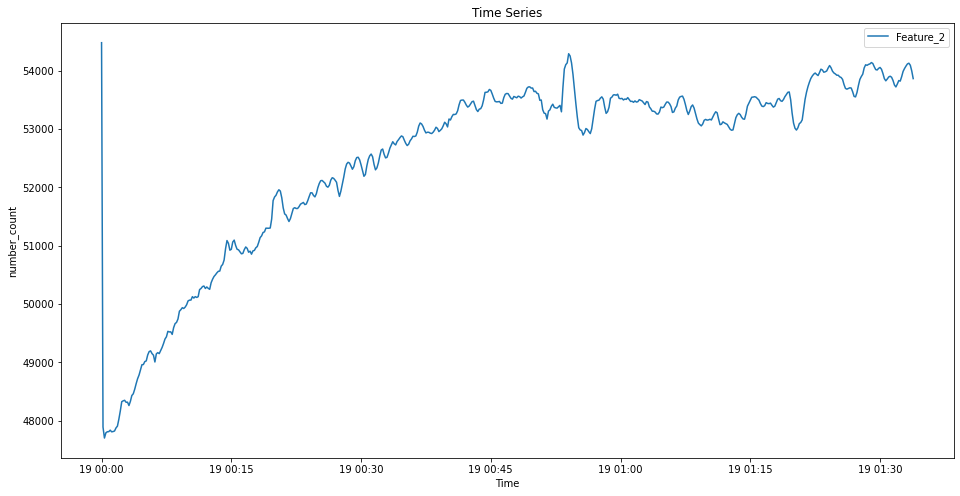

In [17]:
ts = df['feature_2']
plt.figure(figsize=(16,8)) 

plt.plot(ts,label='Feature_2')
# plt.plot(df['feature_1'],label='Other_feture')
plt.title('Time Series') 
plt.xlabel("Time") 
plt.ylabel("number_count") 
plt.legend()

we can see that time is changeing by 15 min with respect to that our Fature 2 is going upwards.


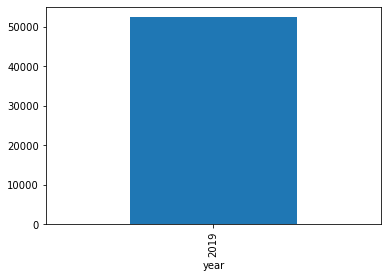

In [18]:
df_train.groupby('year')['feature_2'].mean().plot.bar()

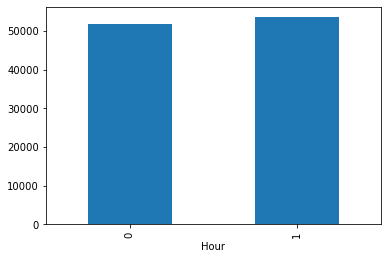

In [19]:
df_train.groupby('Hour')['feature_2'].mean().plot.bar()

we can see only 2 hours are present have no much diffrence in values. it wont give us much insights

now let's try to at understand data by grouping Month and minute

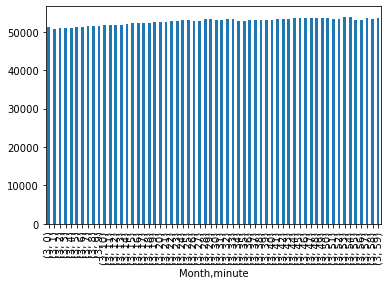

In [20]:
df_train.groupby(['Month','minute'])['feature_2'].mean().plot.bar()

VERY MESSY THEREFORE, NO INSIGHT

# Data Spliting
let's take our copy of datset and start by fresh implementation 

In [22]:
df_train = pd.read_csv(r'/kaggle/input/into-the-future/train.csv')
df_test = pd.read_csv(r'/kaggle/input/into-the-future/test.csv')

preproccesing same as we did in previous section.
and hear we also handle missing values, if any are present

In [23]:
df_train['time'] = pd.to_datetime(df_train['time'],format='%Y-%m-%d %H:%M:%S')
data = df_train.drop('time',1)
data.index = df_train['time']
data = data.drop('id',1)


#missing value treatment
cols = data.columns
for j in cols:
    for i in range(0,len(data)):
       if data[j][i] == -200:
           data[j][i] = data[j][i-1]

there is no missing values in this data set.

now let's divide our training data to caleculate performance and we will keep a copy of splitted data for future use at the time of submission

In [24]:
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]
ttrain = train.copy()
vvalid = valid.copy()

 VECTOR AUTO REGRESSION 
we are selecting this model, since there are 2 features 1) date and 2) feture_1 affecting the target. therfore it is a multivariate time series problem.

In [25]:
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np

model = VAR(endog=np.asarray(train))

model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(valid))
valid.index = range(0,len(valid))

In [26]:
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,2):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check RMSE
import math  
from sklearn.metrics import mean_squared_error
pred.columns = [x[0] for x in pred.columns]
for i in cols:
#     print(pred[i], valid[i])
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for feature_1 is :  29.301804808596287
rmse value for feature_2 is :  505.620846776973


hear we can see our model performance based on rmse value for feature_1 we got 29.301804807619025 and on feature_2 we got 505.62084678844263

now lets see how our model is performence by plotiing graph

In [27]:
#let's chenge our valid index to original index.
valid.index = vvalid.index
pred.index = vvalid.index

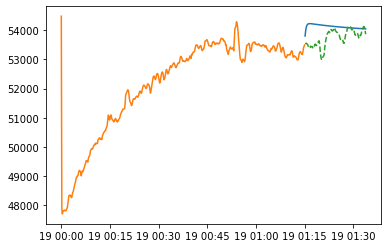

In [28]:
plt.plot(pred['feature_2'])
plt.plot(train['feature_2'])
plt.plot(valid.iloc[:,1:2], '--')
plt.show()

### Summary:  tarining error achived
> #### rmse value for feature_1 is :  29.301804808596287
> #### rmse value for feature_2 is :  505.620846776973

## Prediction on unknown Values

In [29]:
# # let's perform the same preprocessing step on train data as we performed on Training set
df_test['time'] = pd.to_datetime(df_test['time'],format='%Y-%m-%d %H:%M:%S')
pred = df_test.drop('time',1)
pred.index = df_test['time']
pred = pred.drop('id',1)
cols = data.columns




now we will calculate the prediction on future unkown values of Feture_2

In [30]:
prediction = model_fit.forecast(model_fit.y, steps=len(pred))

checking wether the length of the actual and predicted was same so that we can concatinate both of them

In [31]:
if len(prediction) == len(df_test):
    prediction = pd.DataFrame(prediction,columns=['feature_1','feature_2'],index=range(0, len(prediction), 1))
    pred['feature_2'] = list(prediction['feature_2'])
    print("Length mached")
else:
    print("Length Does Not Matched")

Length mached


# Creating a dataframe for Submission

In [33]:
prediction['id'] = index=range(564, 564+len(prediction), 1)
prediction.index = prediction['id']


In [ ]:
prediction =prediction.drop(['id','feature_1'],1)

In [ ]:
prediction

In [ ]:
prediction.to_csv('Solution.csv')

# 2. VARMAX model

> ### note:  other models we can use for multivariate dataset are
> Vector Autoregression Moving-Average (VARMA),
> Holt Winter's Exponential Smoothing (HWES)

now, we let's forget about privious model and start a fresh model by once agin importing data. we can use copy()
but we need to scroll up again and agin, that in what variable we copied.
This is small data set so we can load again

In [ ]:
df_train = pd.read_csv(r"../input/into-the-future/train.csv")
df_test = pd.read_csv(r'../input/into-the-future/test.csv')

This Step is Same as In preivious VAR model preprocessing

In [ ]:
df_train['time'] = pd.to_datetime(df_train['time'],format='%Y-%m-%d %H:%M:%S')
data = df_train.drop('time',1)
data.index = df_train['time']
data = data.drop('id',1)


#missing value treatment
cols = data.columns
for j in cols:
    for i in range(0,len(data)):
       if data[j][i] == -200:
           data[j][i] = data[j][i-1]

train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

let's create our model by impoerting VARMAX from statsmodels

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(train, order = (1,2))
model_fit = model.fit()

Forcasting The values

In [ ]:
predictions_multi = model_fit.forecast( steps=len(valid))

visualizing how our model is getting trained

In [ ]:
plt.plot(train['feature_2'],label='Train')
plt.plot(valid['feature_2'],label = 'valid')
plt.plot(predictions_multi.iloc[:,1:2], '--',label= 'predictions')

plt.title('Time Series') 
plt.xlabel("Time") 
plt.ylabel("feature_2") 
plt.legend()
plt.show()

let's check our RMSE value

In [ ]:
predictions_multi.columns = valid.columns
for i in cols:
    
#     print(pred[i], valid[i])
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(predictions_multi[i], valid[i])))